In [1]:
# Import nilearn and numpy
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
import numpy as np
import pandas as pd
import glob
from nilearn import signal
from scipy import stats
import nibabel as nib
import glob
import os
sk = 3
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# install nsdcode by cloning the repository and following the instructions:
# https://github.com/cvnlab/nsdcode/
from nsdcode.nsd_mapdata import NSDmapdata
from nsdcode.nsd_datalocation import nsd_datalocation
from nsdcode.nsd_output import nsd_write_fs
from nsdcode.utils import makeimagestack

In [3]:
# List all paths
basedir ='/scratch/groups/jyeatman/NSD/ppdata/'
fsdir = '/scratch/groups/jyeatman/NSD/nsddata/freesurfer/'
analysisdir = os.path.dirname(os.path.dirname((basedir))) + '/analysis/'
outputdir = analysisdir + 'clean_18P_scrub025_butter/'
nsd_path = '/scratch/groups/jyeatman/NSD/'
nsd = NSDmapdata(nsd_path)

In [17]:
# Set parameters
overwrite = True
hemi='lh'
droptp = [0,1,2,3,4,5]
subs = ['subj01','subj02','subj03','subj04','subj05','subj06','subj07','subj08']
roi_names = ['vwfa1','vwfa2']
roi_labels = [2,3]
# new labels
new_labels = True
if new_labels:
    roi_names = ['vwfa1','vwfa2','IFSwords','IPSwords']
    roi_names = ['VWFA1','VWFA2','IFSwords','IPSwords']

faces = False
if faces:
    roi_names = ['FFA1_lh','FFA2_lh']
# map volume to surface space
sourcespace = 'func1pt8'
targetspace = hemi+'.layerB2'
interpmethod = 'cubic'

# exclude bad runs
excludeRuns = True
if excludeRuns:
    qc_file = analysisdir + 'QC_FD025.csv'
# for plotting
if hemi == 'lh':
    h = 'left'
elif hemi == 'rh':
    h = 'right'
    # For plotting
bg = 'curv' # options are: 'sulc','curv'

In [5]:
runTtest = True
plotView = False
saveFigs = False

In [12]:
for s,sub in enumerate(subs):
    fssub = fsdir + sub
    bolddir = basedir + sub + '/func1pt8mm/timeseries/'
    motiondir = basedir + sub + '/func1pt8mm/motion/'
    
    lhsurf = surface.load_surf_mesh(fssub + '/surf/'+hemi+'.white')
    labels = surface.load_surf_data(fssub + '/label/'+hemi+'.floc-words.mgz')
    if bg == 'curv':
        bg_map = surface.load_surf_data(fssub + '/surf/'+hemi+'.curv')
        # TEST visualisation with sulcul depth instead of curvature data
    elif bg == 'sulc':
        bg_map = surface.load_surf_data(fssub + '/surf/'+hemi+'.sulc')
    
    
    runs = glob.glob(bolddir + '/timeseries*nii.gz')
    runs.sort()
    run_count = len(runs)
    sub_filepath = outputdir + sub + '_' + str(len(runs)) + 'runs_' + hemi + '.npy'
    roi_zmap = np.load(sub_filepath)
    
    if excludeRuns:
        qc = pd.read_csv(qc_file,sep='\t',header=0)
        filter_runs_idx = qc[(qc['subj']==sub) & (qc['exclude']==True)]['run_id']
        filter_runs_idx = filter_runs_idx.astype('int')
        roi_zmap[:,filter_runs_idx,:]=np.NaN
        run_count = run_count - len(filter_runs_idx)
    
    for rr,roi in enumerate(roi_names):
        outputfile = sub + '_MeanZ_' + roi + '_' + str(run_count) + 'runs_' + hemi + '_' + bg
        mean_map = np.nanmean(roi_zmap[:,:,rr],axis=1)
        
        # Create interactive plot  
        if plotView:
            view = plotting.view_surf(lhsurf, surf_map=mean_map,
            threshold = 0.2, vmax=0.7, colorbar=True,
            bg_map=bg_map,title=outputfile)
            view.save_as_html(outputdir + outputfile+'.html')
        
        # Create figure
        if saveFigs:

#             fig, axes = plt.subplots(2,1,figsize=(5,3),subplot_kw={'projection': '3d'},constrained_layout=True)
#             plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map,
#             hemi=h, threshold = .2, vmax=0.7, view='lateral', colorbar=False,axes=axes[0],
#             bg_map=bg_map,title=None, output_file = None)

#             plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map,
#             hemi=h, threshold = .2, vmax=0.7, view='ventral', colorbar=False,axes=axes[1],
#             bg_map=bg_map,title=None, output_file = None)
            
#             fig.suptitle(sub + roi,fontsize=20)
#             fig.savefig(outputdir + outputfile+'.png')

            plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map,
            hemi=h, threshold = .2, vmax=0.7, view='lateral', colorbar=False,
            bg_map=bg_map,title=None, output_file = outputdir + outputfile+'_lat.png')

            plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map,
            hemi=h, threshold = .2, vmax=0.7, view='ventral', colorbar=False,
            bg_map=bg_map,title=None, output_file = outputdir + outputfile+'_ven.png')

        # Save individual maps as .gii files so we can load them in Freeview

        targetFile = outputdir + outputfile + '.curv'
        if not (os.path.exists(targetFile)) or (overwrite == True):
            nib.freesurfer.io.write_morph_data(targetFile,mean_map)
        
        # Create single sample t-test for each ROI to get statistical significane, not only mean across runs
        targetFile_ttest = str.replace(targetFile,'_MeanZ_','_T1-test_')
        ttest_map,pvals = stats.ttest_1samp(roi_zmap[:,:,rr],0,axis=1)
        if not (os.path.exists(targetFile_ttest)) or (overwrite == True):
            nib.freesurfer.io.write_morph_data(targetFile_ttest,ttest_map)

       
  
    # ROI indices to compare with t-test
    if runTtest:
        roi1=0
        roi2=1

        ttest_map = stats.ttest_rel(roi_zmap[:,:,roi1],roi_zmap[:,:,roi2],nan_policy='omit',axis=1)
        ttest_img_file = outputdir + sub + '_T-test_' + roi_names[roi1] + '_' + roi_names[roi2] + '_' + str(run_count) + 'runs_' + hemi + '_' + bg

        if not (os.path.exists(ttest_img_file)) or (overwrite == True):
            nib.freesurfer.io.write_morph_data(ttest_img_file + '.curv',ttest_map.statistic)
       
        # Plot
        if saveFigs:
            fig =plotting.plot_surf_stat_map(lhsurf, stat_map=ttest_map.statistic, 
            hemi=h, threshold = 4, vmax=12, view='lateral', colorbar=True,
            bg_map=bg_map,title=sub + '_' + str(run_count) + 'runs', output_file = ttest_img_file + '_lat.png')
            print()
            fig =plotting.plot_surf_stat_map(lhsurf, stat_map=ttest_map.statistic, 
            hemi=h, threshold = 4, vmax=12, view='ventral', colorbar=True,
            bg_map=bg_map,title=sub + '_' + str(run_count) + 'runs', output_file = ttest_img_file + '_ven.png')
            print()

            # interactive plot    
            view = plotting.view_surf(lhsurf, surf_map=ttest_map.statistic,
            threshold = 4, vmax=12, colorbar=True,
            bg_map=bg_map,title='t-test')
            view.save_as_html(ttest_img_file+'.html')

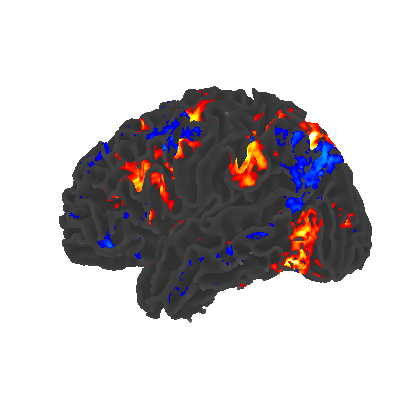

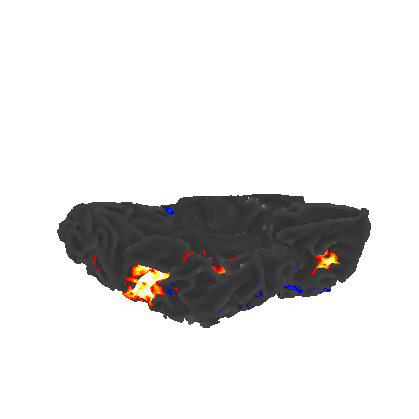

In [24]:
# To plot on a single subject for testing
plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map,
hemi=h, threshold = .2, vmax=0.7, view='lateral', colorbar=False,
bg_map=bg_map,title=None, output_file = None)
print()
plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map,
hemi=h, threshold = .2, vmax=0.7, view='ventral', colorbar=False,
bg_map=bg_map,title=None, output_file = None)
print()

In [35]:
sub = subs[2:3]
filter_runs_idx = qc[(qc['subj']==sub) & (qc['exclude']==True)]['run_id']
filter_runs_idx = filter_runs_idx.astype('int')
roi_zmap[:,filter_runs_idx,:]=np.NaN

In [43]:
roi_zmap[:,8,1]

array([nan, nan, nan, ..., nan, nan, nan])

## Transform results from fsnative to fsaverage

In [24]:
roi_names
hemi='rh'

In [25]:
# we want to transform data from native space 
# (lh.white is the same as B2layer for this purpose, see https://cvnlab.slite.page/p/QtQPzl1xnH/FAQ)
# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage('fsaverage',data_dir = '/home/groups/jyeatman/software')
fsaverage_white = surface.load_surf_data(fsaverage['white_' + h])

fsaverage_data = np.empty([fsaverage_white[0].shape[0],len(subs),len(roi_names)])
fsaverage_data[:] = np.NaN
for s,sub in enumerate(subs):
    fssub = fsdir + sub
    run_count = 20
    #sub_filepath = outputdir + sub + '_' + str(len(runs)) + 'runs_' + hemi + '.npy'
    sub_filepath = outputdir + sub + '_' + str(run_count) + 'runs_' + hemi + '.npy'
    roi_zmap = np.load(sub_filepath) 
    # we want to exclude the bad runs here too
    if excludeRuns:
        qc = pd.read_csv(qc_file,sep='\t',header=0)
        filter_runs_idx = qc[(qc['subj']==sub) & (qc['exclude']==True)]['run_id']
        filter_runs_idx = filter_runs_idx.astype('int')
        roi_zmap[:,filter_runs_idx,:]=np.NaN
        run_count = run_count - len(filter_runs_idx)
    
    for rr,roi in enumerate(roi_names):
        sourcedata = roi_zmap[:,:,rr]
        subjix = int(sub[-1])
        print('Running on ' + sub + ', ' + roi)
        print('Original shape:')
        print(sourcedata.shape)
        
        roi_map_fsaverage = nsd.fit(subjix,
        hemi+'.white',
        'fsaverage',
        sourcedata,
        interptype=None,
        badval=0,
        outputfile=None,
        fsdir=fsdir)
        print('Transformed shape:')
        print(roi_map_fsaverage.shape)
        
        fsaverage_data[:,s,rr]=np.nanmean(roi_map_fsaverage,axis=1)

/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/surface/surface.py:671: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([arr.data for arr in gifti_img.darrays]).T.squeeze()


Running on subj01, VWFA1
Original shape:
(226601, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj01, VWFA2
Original shape:
(226601, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj01, IFSwords
Original shape:
(226601, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj01, IPSwords
Original shape:
(226601, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj02, VWFA1
Original shape:
(239309, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj02, VWFA2
Original shape:
(239309, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj02, IFSwords
Original shape:
(239309, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj02, IPSwords
Original shape:
(239309, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj03, VWFA1
Original shape:
(243023, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj03, VWFA2
Original shape:
(243023, 20

In [26]:
fsaverage_data_all = fsaverage_data.copy()

In [27]:
fsaverage_img_file = outputdir + 'fsaverage_MeanZ_' + hemi + '_' + str(len(subs))

if not os.path.exists(fsaverage_img_file):
    np.save(fsaverage_img_file,fsaverage_data)

# Save ROI maps as curv files for Freeview
for rr,roi in enumerate(roi_names):
    fsaverage_img_file_roi = fsaverage_img_file + roi
    nib.freesurfer.io.write_morph_data(fsaverage_img_file_roi + '.curv',np.nanmean(fsaverage_data[:,:,rr],axis=1))
    print(fsaverage_img_file_roi)
    

/scratch/groups/jyeatman/NSD/analysis/clean_18P_scrub025_butter/fsaverage_MeanZ_rh_8VWFA1
/scratch/groups/jyeatman/NSD/analysis/clean_18P_scrub025_butter/fsaverage_MeanZ_rh_8VWFA2
/scratch/groups/jyeatman/NSD/analysis/clean_18P_scrub025_butter/fsaverage_MeanZ_rh_8IFSwords
/scratch/groups/jyeatman/NSD/analysis/clean_18P_scrub025_butter/fsaverage_MeanZ_rh_8IPSwords


In [28]:
diff_map=np.nanmean(fsaverage_data[:,:,0],axis=1)-np.nanmean(fsaverage_data[:,:,1],axis=1)    
ttest_map = stats.ttest_rel(fsaverage_data[:,:,0],fsaverage_data[:,:,1],nan_policy='omit',axis=1)

fsaverage_img_file_roi = outputdir + 'fsaverage_Ttest_' + hemi + '_' + str(len(subs)) + '_' + roi_names[0] + '_' + roi_names[1]
nib.freesurfer.io.write_morph_data(fsaverage_img_file_roi + '.curv',ttest_map.statistic)

In [29]:
nib.freesurfer.io.write_morph_data(fsaverage_img_file_roi+'diff' + '.curv',diff_map)

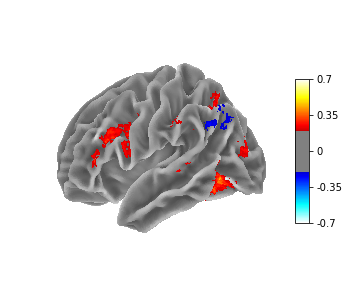

In [25]:
plotting.plot_surf_stat_map(fsaverage['white_' + h], stat_map=np.nanmean(fsaverage_data[:,:,1],axis=1),
hemi=h, threshold = .2, vmax=0.7, view='lateral', colorbar=True,
bg_map=fsaverage['curv_' + h],title=None, output_file = None)
print()

In [ ]:
plotting.plot_surf_stat_map(fsaverage['white_' + h], stat_map=np.nanmean(fsaverage_data[:,:,1],axis=1),
hemi=h, threshold = .2, vmax=0.7, view='lateral', colorbar=True,
bg_map=fsaverage['curv_' + h],title=None, output_file = None)
print()

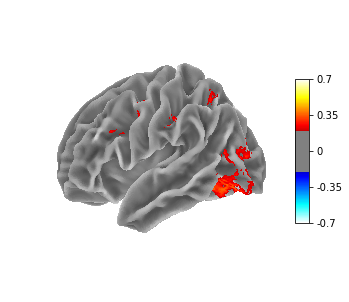

In [27]:
plotting.plot_surf_stat_map(fsaverage['white_' + h], stat_map=np.nanmean(fsaverage_data[:,:,0],axis=1),
hemi=h, threshold = .2, vmax=0.7, view='lateral', colorbar=True,
bg_map=fsaverage['curv_' + h],title=None, output_file = None)
print()

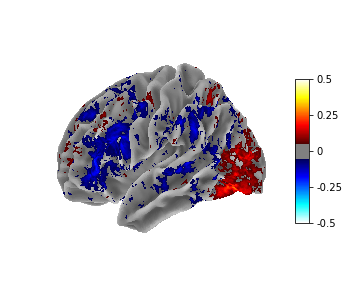

In [28]:
# this cell just shows the old cleaning - 9P
plotting.plot_surf_stat_map(fsaverage['white_' + h], stat_map=np.nanmean(fsaverage_data[:,:,0],axis=1)-np.nanmean(fsaverage_data[:,:,1],axis=1),
hemi=h, threshold = .05, vmax=0.5, view='lateral', colorbar=True,
bg_map=fsaverage['curv_' + h],title=None, output_file = None)
print()

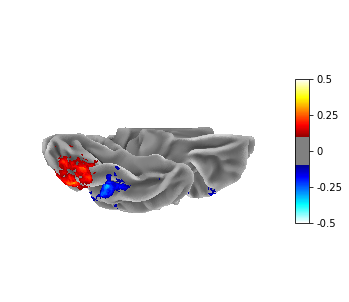

In [37]:
# New cleaning - 36P
plotting.plot_surf_stat_map(fsaverage['white_' + h], stat_map=np.nanmean(fsaverage_data[:,:,0],axis=1)-np.nanmean(fsaverage_data[:,:,1],axis=1),
hemi=h, threshold = .1, vmax=0.5, view='ventral', colorbar=True,
bg_map=fsaverage['curv_' + h],title=None, output_file = None)
print()

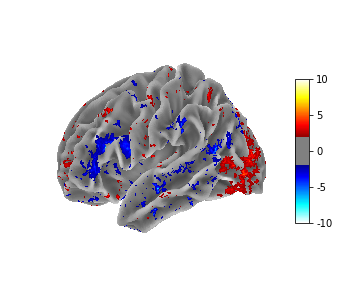

In [41]:
# New cleaning - 36P
ttest_map = stats.ttest_rel(fsaverage_data[:,:,0],fsaverage_data[:,:,1],nan_policy='omit',axis=1)
plotting.plot_surf_stat_map(fsaverage['white_' + h], stat_map=ttest_map.statistic,
hemi=h, threshold = 2, vmax=10, view='lateral', colorbar=True,
bg_map=fsaverage['curv_' + h],title=None, output_file = None)
print()

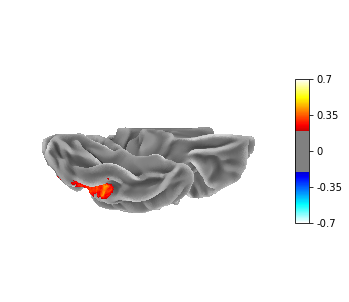

In [42]:
# New cleaning - 36P
plotting.plot_surf_stat_map(fsaverage['white_' + h], stat_map=np.nanmean(fsaverage_data[:,:,3],axis=1),
hemi=h, threshold = .2, vmax=0.7, view='ventral', colorbar=True,
bg_map=fsaverage['curv_' + h],title=None, output_file = None)
print()

## Testing different backgrounds

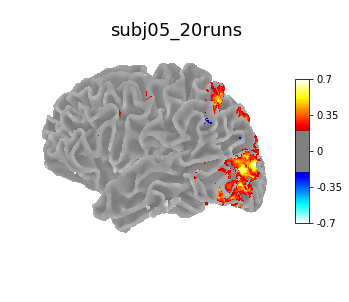

In [21]:
fig =plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map, 
hemi=h, threshold = 0.2, vmax=0.7, view='lateral', colorbar=True,
bg_map=curv,title=sub + '_' + str(len(runs)) + 'runs', output_file =None)
print()

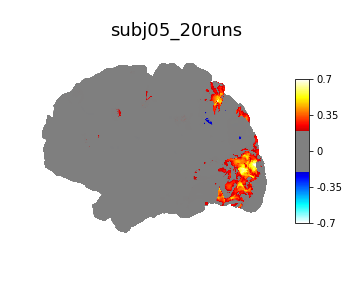

In [22]:
fig =plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map, 
hemi=h, threshold = 0.2, vmax=0.7, view='lateral', colorbar=True,
bg_map=None,title=sub + '_' + str(len(runs)) + 'runs', output_file =None)
print()

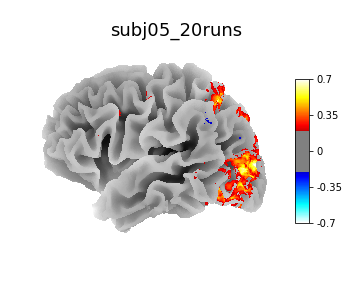

In [24]:
fig =plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map, 
hemi=h, threshold = 0.2, vmax=0.7, view='lateral', colorbar=True,
bg_map=sulc,title=sub + '_' + str(len(runs)) + 'runs', output_file =None)
print()

(array([5.00000e+00, 1.00000e+00, 3.00000e+00, 8.00000e+00, 2.60000e+01,
        2.35000e+02, 1.09727e+05, 1.16920e+05, 8.10000e+01, 1.50000e+01]),
 array([-6.2897396e+00, -5.3913469e+00, -4.4929538e+00, -3.5945611e+00,
        -2.6961682e+00, -1.7977753e+00, -8.9938241e-01, -9.8953245e-04,
         8.9740336e-01,  1.7957962e+00,  2.6941891e+00], dtype=float32),
 <BarContainer object of 10 artists>)

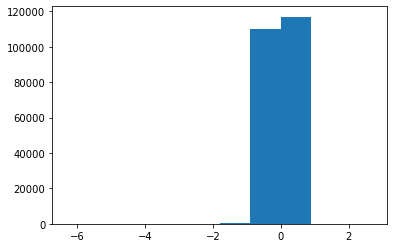

In [11]:
plt.hist(curv)

In [12]:
curv4 = surface.load_surf_data(fsdir + 'subj04' + '/surf/'+hemi+'.curv')

In [14]:
np.unique(curv4)

array([-3.8630211, -3.6134186, -3.5834572, ..., 35.416782 , 38.187855 ,
       38.498875 ], dtype=float32)